In [1]:
# Standard libraries
import numpy as np
import json
import h5py
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display
from sklearn.decomposition import PCA, FastICA

# Append base directory
import os,sys,inspect
rootname = "mesoscopic-functional-connectivity"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
from codes.lib.stat import graph_lib
from codes.lib.info_metrics.corr_lib import corr, crossCorr
from codes.lib.data_io.qt_wrapper import gui_fnames, gui_fpath
from codes.lib.data_io.yasir.data_fc_db import DataFCDatabase
import codes.lib.plots.connectomics as connectomics
import codes.lib.plots.connectomics_db as connectomics_db
import codes.lib.plots.data_plots as data_plots

%load_ext autoreload
%autoreload 2

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Appended root directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-mesoscopic/mesoscopic-functional-connectivity


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['experiment_path']  = gui_fpath("Path to experiment",  './')
#params['experiment_path']  = "/mnt/transfer/Yasir/TE/active_passive"
#params['experiment_path']  = "/mnt/transfer/Yasir/TE/tactile_task_all_trials"
params['experiment_path']  = "/mnt/transfer/Yasir/TE/auditory_task_all_trials"



# params['root_path_te']    = gui_fpath("Select TE results folder", params['root_path_data'])

In [3]:
dataDB = DataFCDatabase(params)

Reading channel label file
Searching for data files


In [4]:
# print(dataDB.mice)
# dataDB.metaDataFrames['neuro']

In [5]:
dataDB.read_neuro_files()
len(dataDB.dataNeuronal)

IntProgress(value=0, description='Read Neuro Data:', max=6)

6

/media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-mesoscopic/mesoscopic-functional-connectivity/codes/lib/stat/stat_lib.py:10: RuntimeWarning: Mean of empty slice
  return np.nanmean(x, axis=axis), np.nanstd(x, axis=axis)
/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


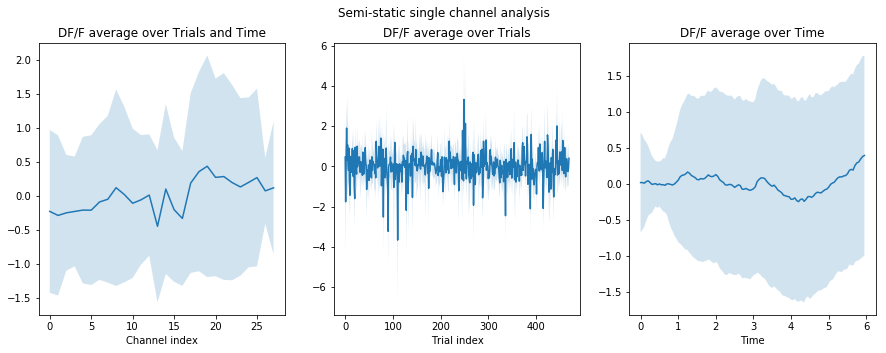

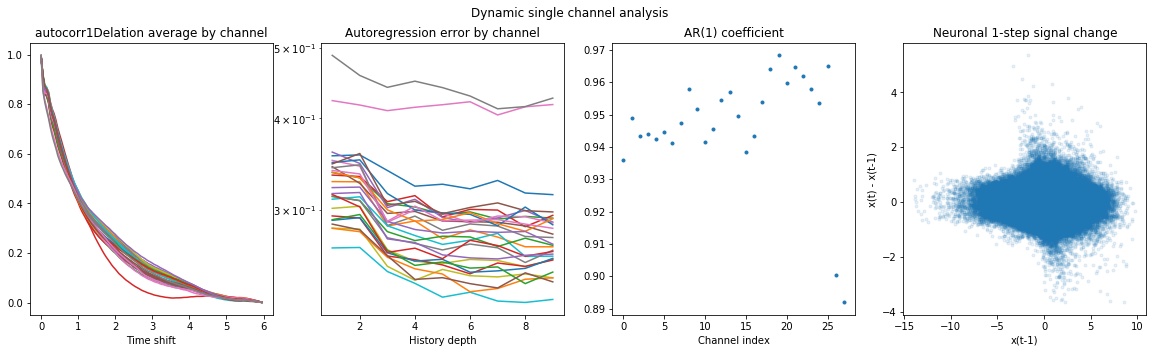

In [9]:
FPS = 20
dataThis = dataDB.dataNeuronal[2]


fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
fig.suptitle("Semi-static single channel analysis")
data_plots.plot_mean_variance_bychannel(ax[0], dataThis)
data_plots.plot_mean_variance_bytrial(ax[1],dataThis)
data_plots.plot_mean_variance_bytime(ax[2], dataThis, fps=FPS)

fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
fig.suptitle("Dynamic single channel analysis")
data_plots.plot_autocorrelation_bychannel(ax[0], dataThis, fps=FPS, withFill=False)
data_plots.plot_ar(ax[1], ax[2], dataThis, histMax=10, fps=FPS)
data_plots.plot_fit_gamma(ax[3], dataThis)

plt.show()

In [7]:


def pca_analysis(data, thr):
    # Flatten times and trials
    nTrial, nTime, nChannel = data.shape
    dataThis = data.reshape((nTrial*nTime, nChannel))
    
    # Drop all cols if there is at least one NAN
    nanColIdxs = np.any(np.isnan(dataThis), axis=1)
    print("For shape", dataThis.shape, "total nan columns", np.sum(nanColIdxs))
    dataThis = dataThis[~nanColIdxs]
    print("After dropping NAN cols, final shape is", dataThis.shape)

    # Z-score data
    dataThis = zscore2D(dataThis)
    
    # Compute principal components
    pca = PCA()
    dataPCA = pca.fit_transform(dataThis)
    corrmat = np.corrcoef(dataThis.T)
    evalsPCA = pca.explained_variance_ratio_
    evecsPCA = pca.inverse_transform(np.eye(nChannel))
    
    print("Average explains", evals[0], "percent of all variance")
    
    # Threshold eigenvalues
    evalPCAThrIdxs = evalsPCA < thr
    nBadEvalPCA = np.sum(evalPCAThrIdxs)
    nGoodEvalPCA = nChannel-nBadEvalPCA
    if nBadEvalPCA > 0:
        print("Total", nBadEvalPCA, "evals below threshold of", thr)
        print("Writing significant channel combinations for each eigenvalue")
    else:
        print("All evals appear significant up to threshold of", thr)
    
    for evalue, evec in zip(evalsPCA[evalPCAThrIdxs], evecsPCA[evalPCAThrIdxs]):
        print(evalue, ':::', np.where(np.abs(evec) > 0.01)[0])
        
    # ICA
    ica = FastICA()
    dataICA = ica.fit_transform(dataPCA[:, ~evalPCAThrIdxs])
    evecsICAinPCA = ica.inverse_transform(np.eye(nGoodEvalPCA))
    evecsICAinPCAaug = np.zeros((nGoodEvalPCA, nChannel))
    evecsICAinPCAaug[:, ~evalPCAThrIdxs] = evecsICAinPCA
    evecsICA = pca.inverse_transform(evecsICAinPCAaug)
    
    for evec in evecsICA:
        evec /= np.sum(evec**2)
    
    varICA = np.var(evecsICA.dot(dataThis.T), axis=1)
    varICAargsort = np.flip(np.argsort(varICA))
    varICA = varICA[varICAargsort]
    evecsICA = evecsICA[varICAargsort]
    varICA /= np.sum(varICA)

    # Plot results
    nCols = 6
    fig, ax = plt.subplots(ncols=nCols, figsize=(nCols*4, 4))
    ax[0].imshow(corrmat)
    ax[1].semilogy(evalsPCA, '.')
    ax[1].axhline(y=thr, color='r', linestyle='--')
    ax[2].semilogy(evalsPCA, '.')
    ax[2].set_ylim([thr, 1])
    ax[3].imshow(evecsPCA)
    ax[4].imshow(evecsICA)
    ax[5].semilogy(varICA, '.')
    ax[0].set_title("Correlation")
    ax[1].set_title("Explained variance")
    ax[2].set_title("Explained variance, magnified")
    ax[3].set_title("Principal components")
    plt.show()

For shape (60000, 28) total nan columns 8361
After dropping NAN cols, final shape is (51639, 28)
Average explains 0.7116587192198157 percent of all variance
Total 1 evals below threshold of 0.0001
Writing significant channel combinations for each eigenvalue
5.111515681485179e-33 ::: [26 27]


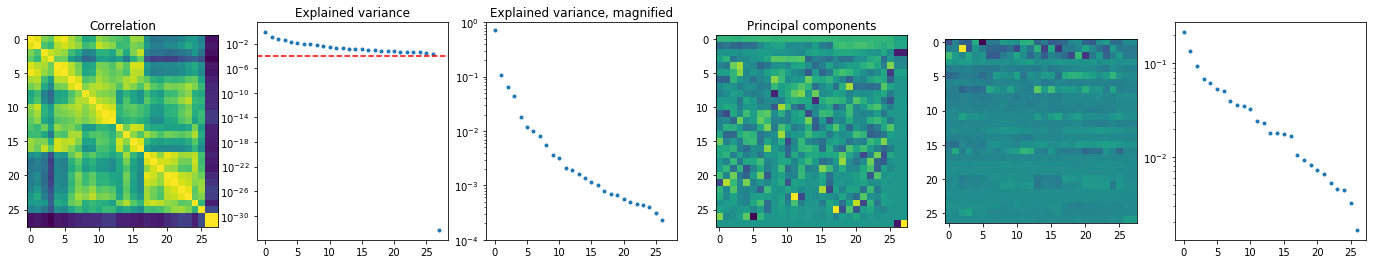

For shape (49320, 28) total nan columns 1759
After dropping NAN cols, final shape is (47561, 28)
Average explains 0.7116587192198157 percent of all variance
All evals appear significant up to threshold of 0.0001


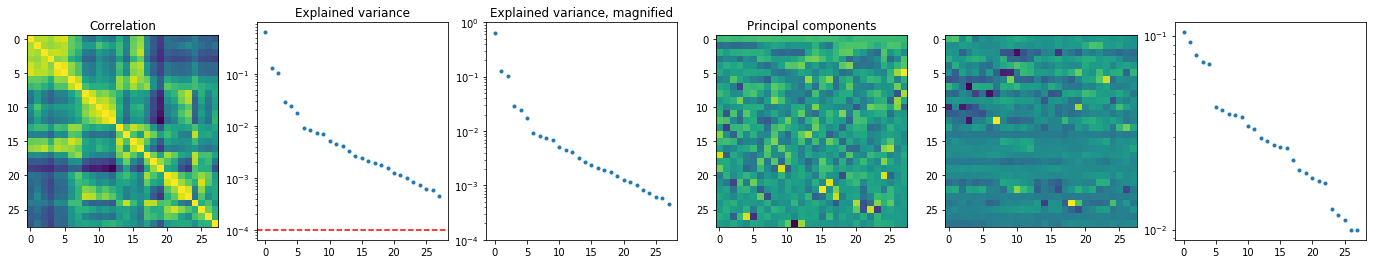

For shape (56400, 28) total nan columns 16876
After dropping NAN cols, final shape is (39524, 28)
Average explains 0.7116587192198157 percent of all variance
All evals appear significant up to threshold of 0.0001


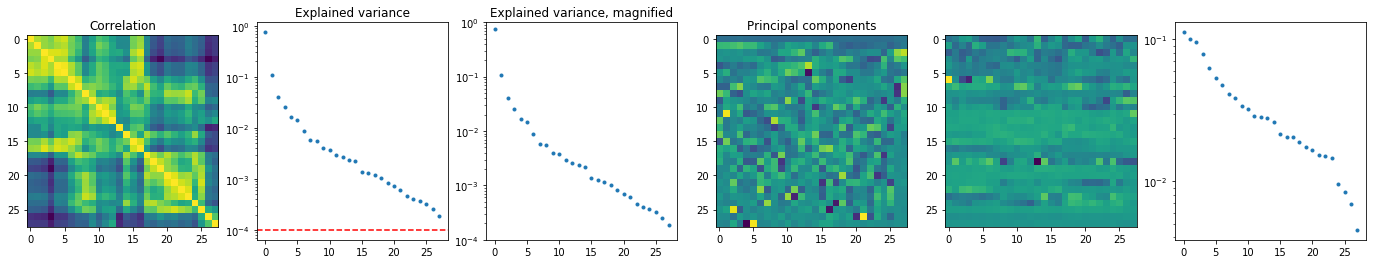

For shape (100000, 28) total nan columns 25565
After dropping NAN cols, final shape is (74435, 28)
Average explains 0.7116587192198157 percent of all variance
All evals appear significant up to threshold of 0.0001


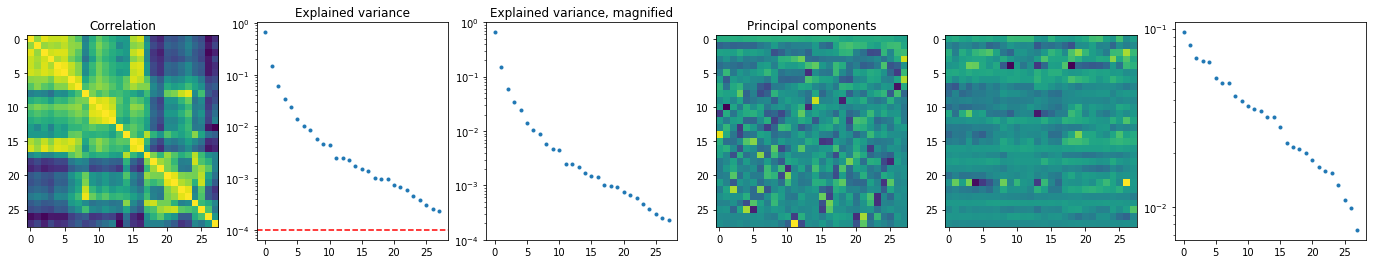

For shape (60000, 28) total nan columns 6808
After dropping NAN cols, final shape is (53192, 28)
Average explains 0.7116587192198157 percent of all variance
All evals appear significant up to threshold of 0.0001


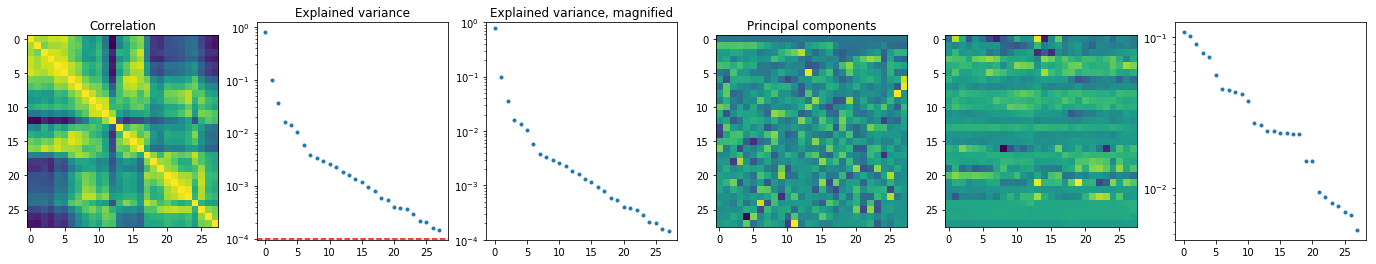

For shape (51360, 28) total nan columns 2407
After dropping NAN cols, final shape is (48953, 28)
Average explains 0.7116587192198157 percent of all variance
Total 2 evals below threshold of 0.0001
Writing significant channel combinations for each eigenvalue
8.02376237670493e-05 ::: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 19 20 21 22 23 24 25
 26]
6.939792977559457e-05 ::: [ 0  1  3  4  5  6  7  8  9 11 13 15 16 18 19 20 21 22 23 25]


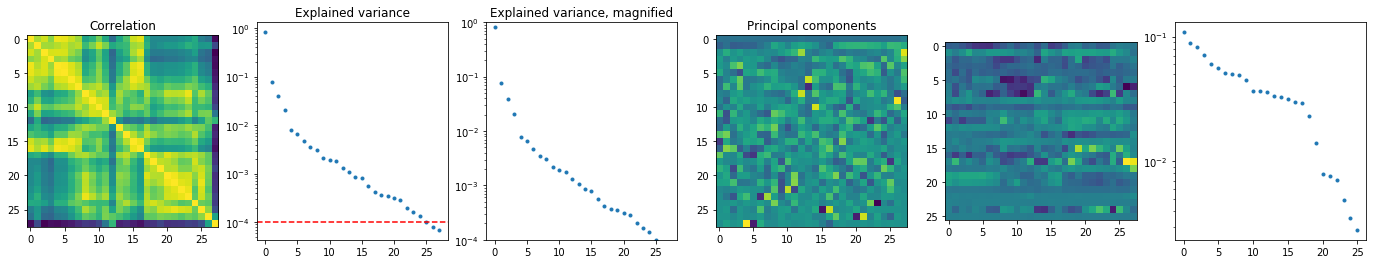

In [104]:
for data in dataDB.dataNeuronal:
    pca_analysis(data, thr=1.0E-4)

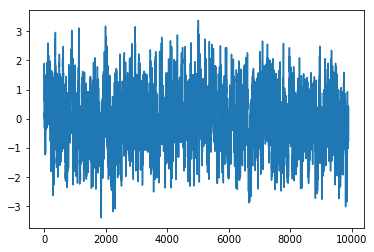

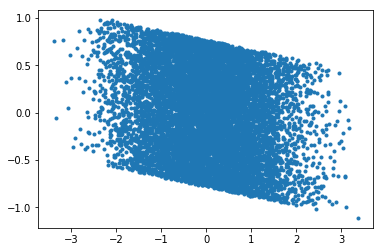

In [162]:
N = 10000
aaa = np.random.uniform(0,1,N)
for i in range(1, N):
    aaa[i] += aaa[i-1] * 0.9

aaa = aaa[100:]
aaa = (aaa - np.mean(aaa)) / np.std(aaa)
    
plt.figure()
plt.plot(aaa)

plt.figure()
plt.plot(aaa[:-1], aaa[1:] - aaa[:-1], '.')
plt.show()